## Курсовая работа

## Настройка

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()


## Извлечение данных

In [3]:
images_folder = "../data/archive/Semantic segmentation dataset"

In [ ]:
class AerialImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transforms=None):
        super(AerialImageDataset, self).__init__()
        self.file_root = root
        self.is_training = training
        self.tranforms = transforms
        self.IMG_NAMES = sorted(glob(self.file_root + '/*/images/*.jpg'))
        # Объявление маск классов
        self.RGB_classes = {'Water': [226, 169, 41],
                            'Land': [132, 41, 246],
                            'Road': [110, 193, 228],
                            'Building': [60, 16, 152],
                            'Vegetation': [254, 221, 58],
                            'Unlabeled': [155, 155, 155]}
        self.bin_classes = list(self.RGB_classes.keys())


    # преобразует rgb маску в инлексы классов
    def rgb_to_class(self, mask):
        class_mask = np.zeros(mask.shape[:2], dtype=int)
        for label, rgb in self.RGB_classes.items():
            class_mask[(mask == rgb).all(axis=2)] = self.bin_classes.index(label)
        return class_mask

    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        image_mask = self.rgb_to_class(mask) 

        # Применение преобразований данных(поворот, отражения, прмменение трансофрмаций)
        if self.is_training:
            if self.tranforms:
                image = Image.fromarray(image)
                image = self.tranforms(image)
                image = np.array(image)
            if np.random.rand() < 0.5:
                angle = np.random.randint(4) * 90
                image = ndimage.rotate(image, angle, reshape=True)
                image_mask = ndimage.rotate(image_mask, angle, reshape=True)
            if np.random.rand() < 0.5:
                image = np.flip(image, 0)
                image_mask = np.flip(image_mask, 0)
            if np.random.rand() < 0.5:
                image = np.flip(image, 1)
                image_mask = np.flip(image_mask, 1)
        
        image = cv2.resize(image, (512, 512)) / 255.0
        image_mask = cv2.resize(image_mask.astype(np.uint8), (512, 512), interpolation=cv2.INTER_NEAREST)
        image = np.moveaxis(image, -1, 0)
        return torch.tensor(image).float(), torch.tensor(image_mask, dtype=torch.int64)


    # возвращает размер датасета
    def __len__(self):
        return len(self.IMG_NAMES)


## Подготовка данных

In [5]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))
t = transforms.Compose([color_shift, blurriness])
dataset = AerialImageDataset(images_folder, training = True, transforms= t)
print(f"Len: {len(dataset)}")

Len: 72


### Прмер изображений и их масок

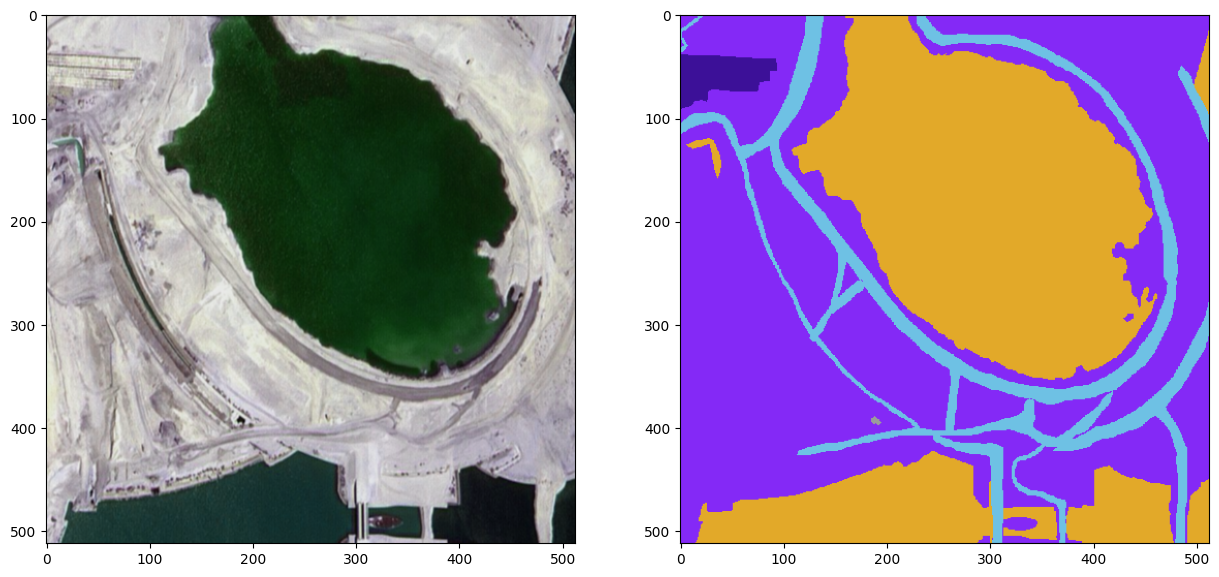

In [ ]:
d = dataset[4]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
# оригинальное изображение
plt.imshow(np.moveaxis(d[0].numpy(),0,-1)) 
plt.subplot(1,2,2)
color_mask = np.zeros((d[1].shape[0], d[1].shape[1], 3), dtype=np.uint8)
for label, rgb in dataset.RGB_classes.items():
    color_mask[d[1] == dataset.bin_classes.index(label)] = rgb
plt.imshow(color_mask)
plt.show()

In [ ]:
test_num = int(0.1 * len(dataset))
print(f'Test size: {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(4323245))
BATCH_SIZE = 1
# Инициализирует загрузчик данных для тестирования и тренировки
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Test size: 7


In [10]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')
    
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

device = get_device()

train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Модель U-Net


In [ ]:
# Слои нейросети, расположенный после апскейла или даунсемплинга
class MiddleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Слой енкодера
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            MiddleLayer(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
# Слой декодера
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = MiddleLayer(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = MiddleLayer(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
# Последний слой U-Net
class LastConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LastConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = MiddleLayer(n_channels, 64, 64)
        self.down1 = EncoderBlock(64, 128)
        self.down2 = EncoderBlock(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = EncoderBlock(256, 512 // factor)
        self.down4 = EncoderBlock(512, 1024 // factor)
        self.down5 = EncoderBlock(1024, 2048 // factor)

        self.up0 = DecoderBlock(2048, 1024 // factor, bilinear)
        self.up1 = DecoderBlock(1024, 512 // factor, bilinear)
        self.up2 = DecoderBlock(512, 256 // factor, bilinear)
        self.up3 = DecoderBlock(256, 128 // factor, bilinear)
        self.up4 = DecoderBlock(128, 64, bilinear)
        self.outc = LastConv(64, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        # x5 = self.down4(x4)
        # x6 = self.down5(x5)

        # x = self.up0(x6, x5)
        # x = self.up1(x, x4)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## 4. Функции потерь

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

        if isinstance(alpha,(float,int)):
          self.alpha = torch.Tensor([alpha,1-alpha])

        if isinstance(alpha,list):
           self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            # Если изоьражение имеет больше 2 каналов то изменить его размер
            input = input.view(input.size(0),input.size(1),-1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1,input.size(2))
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        # вес для каждого класса
        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [15]:
class DiceLoss(nn.Module):

    def __init__(self, smooth=1e-5, ignore_index=None, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.shape[1]
        inputs = F.softmax(inputs, dim=1)

        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

        if self.ignore_index is not None:
            mask = targets != self.ignore_index
            inputs = inputs * mask.unsqueeze(1)
            targets_one_hot = targets_one_hot * mask.unsqueeze(1).float()

        intersection = torch.sum(inputs * targets_one_hot, dim=(0, 2, 3))
        union = torch.sum(inputs + targets_one_hot, dim=(0, 2, 3))

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score

        if self.reduction == 'mean':
            return dice_loss.mean()
        elif self.reduction == 'sum':
            return dice_loss.sum()
        else:
            return dice_loss


In [ ]:
# Инициализация функции потерь
criterion = DiceLoss(smooth=1e-5, ignore_index=5, reduction='mean').to(device)
# criterion = FocalLoss(gamma=3/4).to(device)

## 5. Обучение

In [ ]:
# Функция для вычиления accuracy
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

# Функция для вычисления precision
def precision(y, pred, classes = 6):
    precision_list = [];
    for i in range(classes):
        # вычисляет precision для каждого класса
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred, axis=1).cpu()

        # вычисляет recall для класса i
        prec = torch.logical_and(actual_num,predicted_num).sum()/predicted_num.sum()
        precision_list.append(prec.numpy().tolist())
    return precision_list

# Функция для вычиления recall
def recall(y, pred, classes = 6):
    recall_list = []
    for i in range(classes):
        # вычисляет recall для каждого класса
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred, axis=1).cpu()

        # вычисляет reecall для класса i
        recall_val = torch.logical_and(actual_num, predicted_num).sum() / actual_num.sum()
        recall_list.append(recall_val.numpy().tolist())
    return recall_list

In [ ]:
min_loss = torch.tensor(float('inf'))
model = UNet(n_channels=3, n_classes=6, bilinear=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
os.makedirs('./saved_models1', exist_ok=True)

N_EPOCHS = 30

N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []

counter = 0


min_loss = float('inf')

for epoch in range(N_EPOCHS):

    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0
    train_loop = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{N_EPOCHS}] Training", leave=False)
    for x, y in train_loop:
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc(y, pred).item()

        train_loop.set_postfix(loss=loss.item())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Типо валидация на трейне 
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        val_loop = tqdm(test_dataloader, desc=f"Epoch [{epoch+1}/{N_EPOCHS}] Validation", leave=False)
        for x, y in val_loop:
            pred = model(x.to(device))
            loss = criterion(pred, y.to(device))

            val_loss += loss.item()
            val_acc += acc(y, pred).item()
            val_loop.set_postfix(loss=loss.item())
        
    val_loss /= len(test_dataloader)
    val_acc /= len(test_dataloader)


    print(f'Epoch {epoch+1}/{N_EPOCHS} - loss: {train_loss:.5f} - Acc: {train_acc:.2f} - Val Loss: {val_loss:.5f} - Val Acc: {val_acc:.2f}')

    plot_losses.append([epoch, train_loss, val_loss])

   
    
    if counter % 5 == 0:
        torch.save(model.state_dict(), f'./saved_models1/focal/unet_small_epoch_{epoch}_{val_loss:.5f}.pt')
    
    
    if counter > 5:
        lr_scheduler.step()
        print(f"Lowering learning rate to {optimizer.param_groups[0]['lr']}")
        counter = 0
    
    counter += 1


Epoch [1/30] Training:   0%|          | 0/65 [00:00<?, ?it/s]

/home/wayzap/Projects/Python/venvs/venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [ ]:
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('Focal Loss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation'])
plt.show()

## 6. Тестирование

### Colorized output 

In [ ]:
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x[j:j+1].to(device))

        # Отображение предсказанной маски
        pred = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        color_pred_mask = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        for label, rgb in dataset.RGB_classes.items():
            color_pred_mask[pred == dataset.bin_classes.index(label)] = rgb

        # Истинная маска
        gt_mask = y[j].cpu().numpy()
        color_gt_mask = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3), dtype=np.uint8)
        for label, rgb in dataset.RGB_classes.items():
            color_gt_mask[gt_mask == dataset.bin_classes.index(label)] = rgb
        
        # Входное изображение
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy() * 255
        im = im.astype(np.uint8) 

        # Отображение изображений
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(im)

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(color_gt_mask)

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(color_pred_mask)
        plt.show()

In [ ]:
pred_list = []
gt_list = []
precision_list = []
recall_list = []

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        

        # Получает предсказхание по изображению 
        result = model(x.to(device)[j:j+1])

        # Вычисляет prec и recall для кажлого изображения 
        precision_list.append(precision(y[j],result))
        recall_list.append(recall(y[j],result))

In [ ]:
# вычисляет prec для каждого класса
print(f"Mean prec: {np.nanmean(precision_list,axis = 0)}")

In [ ]:
# вычисляет recall для каждого класса
print(f"Mean recall: {np.nanmean(recall_list,axis = 0)}")

In [ ]:
# вычисляет средний presicion для каждлого класса
mean_precision = np.nanmean(precision_list,axis = 0)
print(f"Final precision value: {sum(mean_precision[:-1])/5}")
# вычисляет средний recall для каждого класса
mean_recall = np.nanmean(recall_list,axis = 0)
print(f"Final recall value: {sum(mean_recall)/5}")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_iou(confusion_matrix):
    intersection = np.diag(confusion_matrix)
    union = (confusion_matrix.sum(1) + confusion_matrix.sum(0)) - intersection
    iou = intersection / union.astype(np.float32)
    return iou.mean()

def calculate_mIoU(predicted, target):
    num_classes = max(np.max(target), np.max(predicted)) + 1
    confusion_mat = confusion_matrix(target.flatten(), predicted.flatten(), labels=range(num_classes))
    class_iou = calculate_iou(confusion_mat)
    return class_iou


model.eval()

total_mIoU = 0.0
total_batches = 0

for batch_i, (x, y) in enumerate(test_dataloader):

    for j in range(len(x)):

        result = model(x[j:j+1])

        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]

        gt_mask = y[j].cpu().numpy()

        mIoU = calculate_mIoU(mask, gt_mask)
        total_mIoU += mIoU
        total_batches += 1

# Вычисляет средний IoU по всем классам
average_mIoU = total_mIoU / total_batches
print("Average mIoU:", average_mIoU)